# Import library

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os
import matplotlib.pyplot as plt
import datetime as dt

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set Random Seed

In [9]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


# Global variables

In [10]:
EPOCHS = 100
BATCH_SIZE = 8
WINDOW = 5
HORIZON = 1
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.5


# Load data

In [11]:
AAPL = pd.read_csv('./Dataset_A/AAPL.csv', parse_dates=True)

AAPL['Date'] = pd.to_datetime(AAPL['Date'])
AAPL.set_index('Date', inplace=True)

# EDA

In [12]:
AAPL.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000
1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400
1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400

<Axes: xlabel='Date'>

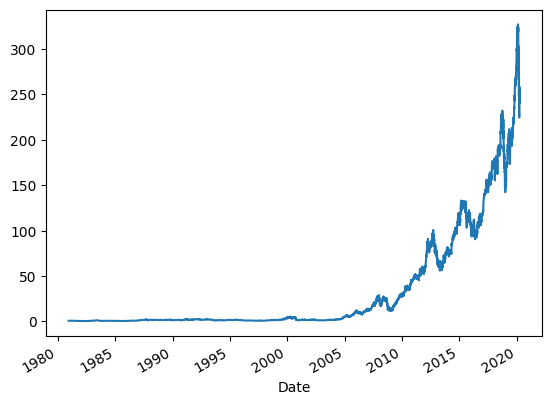

In [13]:
AAPL['Close'].plot()

In [14]:
AAPL['Close'].describe()

count    9909.000000
mean       32.618030
std        58.471899
min         0.196429
25%         1.071429
50%         1.732143
75%        35.761429
max       327.200012
Name: Close, dtype: float64

## Missing Values

In [15]:
AAPL.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Preprocessing

## Drop Unnecessary Columns

In [16]:
AAPL_close = AAPL.copy()[['Close']]
AAPL_close.head()

Close
Date                
1980-12-12  0.513393
1980-12-15  0.486607
1980-12-16  0.450893
1980-12-17  0.462054
1980-12-18  0.475446

## Data Normalization

In [17]:
data = AAPL_close.values.tolist()

class MinMaxScaling:
    def __init__(self, data):
        self.data = np.array(data, dtype='float32')
        self.min = self.data.min(axis=0)
        self.max = self.data.max(axis=0)
    
    def __call__(self):
        return list((self.data - self.min)/(self.max - self.min))
    
    def inverse(self, data):
        return list(data*(self.max - self.min) + self.min)

min_max_scaler = MinMaxScaling(data)

In [18]:
data = min_max_scaler()

## Create TimeSeries Instances

In [19]:
def create_instances(data, window : int = 1, future : int = 1):
    X, y = [], []
    for i in range(len(data)-window-future):
        feature = data[i : i+window]
        # target = data[i+future+1 : i+window+future+1]
        target = data[i+window+future]
        X.append(feature)
        y.append(target)
    return X, y

In [20]:
X, y = create_instances(data, window=WINDOW, future=HORIZON)

## Split Data (Train, Validation, Test)

In [21]:
# Split the data with 80% for training and 10% for validation and 10% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SPLIT, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=VAL_SPLIT, shuffle=False, random_state=42)

## Convert Data to Tensor Slices

In [22]:
# Convert the data to tensors and create dataloaders

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Base Model (LSTM)

## Define Model Architecture

In [23]:
input_layer = Input(shape=(WINDOW, 1))
lstm_layer = LSTM(50, activation='relu')(input_layer)
output_layer = Dense(1)(lstm_layer)
base_model = Model(input_layer, output_layer)

In [24]:
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [37]:
base_model.compile(optimizer=Adam(), loss='mae', metrics=[RootMeanSquaredError(), 'mae', 'mape'])

## Train Model

In [38]:
checkpointer = ModelCheckpoint(filepath = './exp/AAPL/weights_best.hdf5.keras', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

his_baseModel=base_model.fit(train_data, 
               epochs=EPOCHS, 
               validation_data=val_data, 
               batch_size=BATCH_SIZE, 
               callbacks=[checkpointer, early_stopping])

Epoch 1/100
961/991 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0012 - mape: 184.6622 - root_mean_squared_error: 0.0029
Epoch 1: val_loss improved from inf to 0.01305, saving model to ./exp/AAPL/weights_best.hdf5.keras
991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0012 - mae: 0.0012 - mape: 180.5368 - root_mean_squared_error: 0.0029 - val_loss: 0.0130 - val_mae: 0.0130 - val_mape: 4.7622 - val_root_mean_squared_error: 0.0159
Epoch 2/100
973/991 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - mae: 0.0023 - mape: 715.7156 - root_mean_squared_error: 0.0051
Epoch 2: val_loss improved from 0.01305 to 0.01130, saving model to ./exp/AAPL/weights_best.hdf5.keras
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - mae: 0.0023 - mape: 706.0831 - root_mean_squared_error: 0.0050 - val_loss: 0.0113 - val_mae: 0.0113 - val_mape: 4.4276 - val_root_mean_squared_error: 0.0132
Epoch 3/100
959/991 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mape: 362.0538 - r

## Evaluate Model

In [39]:
print('Best Validation Loss (MAE): ', min_max_scaler.inverse(min(his_baseModel.history['val_loss'])))
print('Best Training Loss (MAE): ', min_max_scaler.inverse(min(his_baseModel.history['loss'])))
print('Best MAPE: ',min(his_baseModel.history['val_mape']))

Best Validation Loss (MAE):  [3.403653]
Best Training Loss (MAE):  [0.5174973]
Best MAPE:  3.6349456310272217


Terdapat rata-rata deviasi absolut sebesar 4 dan MAPE sebesar 4% pada set validasi. Hal ini dapat diartikan bahwa model prediksi harga saham memiliki rata-rata deviasi sebesar 4% atau 4 dollar. Hasil yang sangat baik

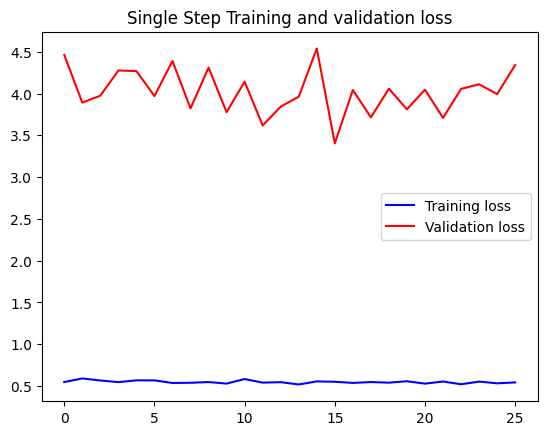

In [40]:
def plot_train_history(history, title):
    loss = min_max_scaler.inverse(history.history['loss'])
    val_loss = min_max_scaler.inverse(history.history['val_loss'])

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(his_baseModel, 'Single Step Training and validation loss')

Model Overfitting jadi next model yang lebih simple

LINK VIDIO : https://drive.google.com/drive/folders/17OsVnTnXQ-l2GP-p-oKE7ZNvTqZSHyTl?usp=drive_link